# Get the data and imports

In [1]:
!wget -nc https://lazyprogrammer.me/course_files/SPY.csv

--2023-03-07 18:02:05--  https://lazyprogrammer.me/course_files/SPY.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 251935 (246K) [text/csv]
Saving to: ‘SPY.csv’

SPY.csv             100%[===================>] 246.03K   522KB/s    in 0.5s    

2023-03-07 18:02:07 (522 KB/s) - ‘SPY.csv’ saved [251935/251935]



In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [32]:
df = pd.read_csv('SPY.csv', index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,92.246048,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.490204,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.555328,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.946060,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,93.255348,126402800


# Calculate the Rolling Slow and Fast Means with Random Selected Windows

In [33]:
df['logReturn'] = np.log(df['Close']).diff() # log return of the next day
df['logReturn'] = df['logReturn'].shift(-1) # shift the log return by 1 day
df['SlowSMA'] = df['Close'].rolling(30).mean() # 30-day simple moving average
df['FastSMA'] = df['Close'].rolling(10).mean() # 10-day simple moving average
df.head()

,Open,High,Low,Close,Adj Close,Volume,logReturn,SlowSMA,FastSMA
Date,,,,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,92.246048,118944600,0.002644,NaN,NaN
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.490204,111579900,0.000704,NaN,NaN
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.555328,116074400,0.004212,NaN,NaN
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.946060,131091100,0.003322,NaN,NaN
2010-01-08,113.889999,114.620003,113.660004,114.570000,93.255348,126402800,0.001396,NaN,NaN


<Axes: xlabel='Date'>

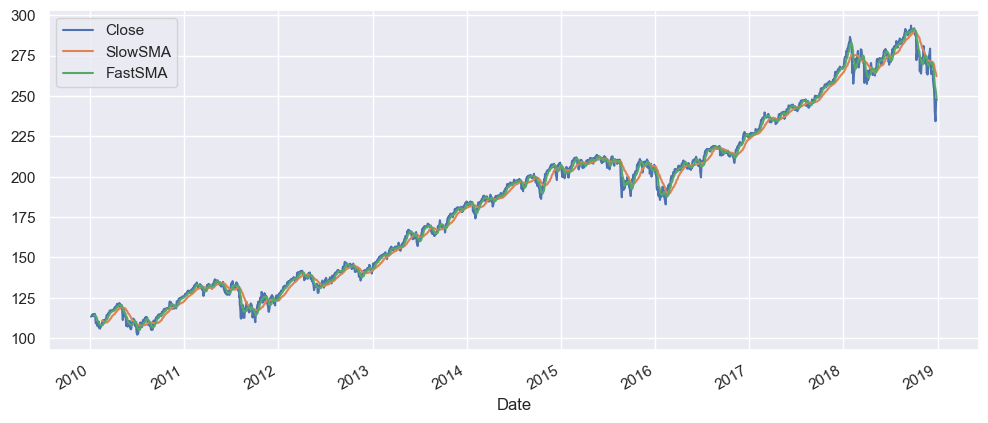

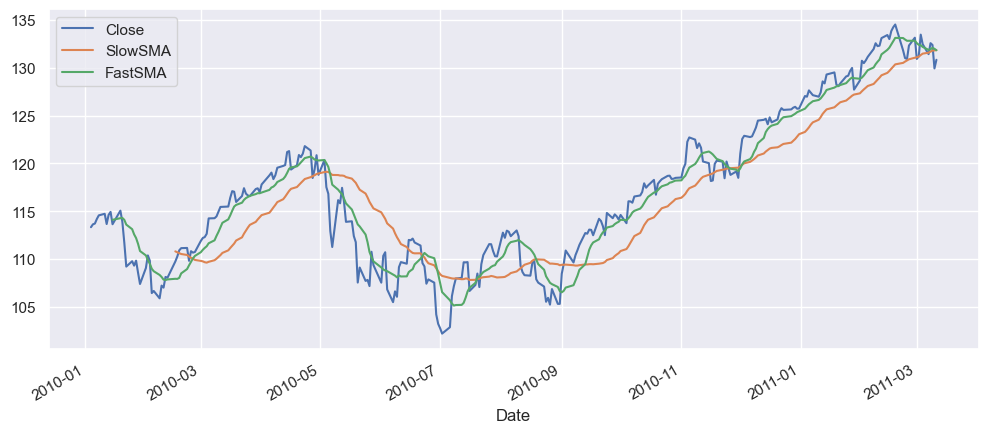

In [34]:
df[['Close', 'SlowSMA', 'FastSMA']].plot(figsize=(12, 5))
df[['Close', 'SlowSMA', 'FastSMA']].iloc[:300].plot(figsize=(12, 5))

In [35]:
# Determine the buy or sell signal based on the SMA crossover
df['Signal'] = np.where(df['FastSMA'] > df['SlowSMA'], 1, 0)

In [36]:
# shift the signal by 1 day to make the signal of the next day available today (for trading) 
df['PrevSignal'] = df['Signal'].shift(1)

In [39]:
df['Buy'] = ( (df['PrevSignal'] == 0) & (df['Signal'] == 1) ) # buy signal is when Fast < Slow and the next day Fast > Slow
df['Sell'] = ( (df['PrevSignal'] == 1) & (df['Signal'] == 0) ) # sell signal is when Fast > Slow and the next day Fast < Slow
# if the signal is the same, then we hold the position (no buy or sell)

In [41]:
# Write a function which determines for each step if we are invested or not

is_invested = False

def determine_invested(row):
    global is_invested
    if is_invested == True and row['Sell'] == True:
        is_invested = False
    if is_invested == False and row['Buy'] == True:
        is_invested = True

    # otherwise hold
    return is_invested
    
df['IsInvested'] = df.apply(determine_invested, axis=1)


In [45]:
df['AlgoLogReturn'] = df['IsInvested'] * df['logReturn'] # if we are invested, then we take the log return, otherwise 0

In [47]:
print('Algo log return: ', df['AlgoLogReturn'].sum())
print('Buy and hold log return: ', df['logReturn'].sum())

Algo log return:  0.3049019540291429
Buy and hold log return:  0.782116240308401


Thus, we can see that in this instance, the SMA trend following approach is performing worse than the buy-and-hold resul. 

In [48]:
# Calculate the standard deviation and sharp ratio of the log return and of the buy-and-hold strategy
# We assume the risk-free rate is 0 (no risk-free rate)

print('Algo log return standard deviation: ', df['AlgoLogReturn'].std())
print('Buy and hold log return standard deviation: ', df['logReturn'].std())

print('Algo sharp ratio: ', df['AlgoLogReturn'].mean() / df['AlgoLogReturn'].std())
print('Buy and hold sharp ratio: ', df['logReturn'].mean() / df['logReturn'].std())

Algo log return standard deviation:  0.00608988006417083
Buy and hold log return standard deviation:  0.009446971193167572
Algo sharp ratio:  0.022133947090060876
Buy and hold sharp ratio:  0.036600423640896725


Although we minimise risk, we also have a lower sharp ratio